# Data Cleansing

This notebook shows some data cleansing strategies you may use.


## Load the data

In [38]:
# Import required libraries
import pandas as pd
import numpy as np
from functions import *

Load our very small data set.

In [39]:
# Load data
df = pd.read_csv("../data/csv/cleaning.csv")
df

,location,date_of_sale,number_of_bedrooms,price,type
0,Clapham,12/04/1999,1,"£729,000",apartment
1,Ashford,05/08/2017,unknown,"£699,000",semi-detached
2,Stratford-on-Avon,29/03/2012,3,NaN,detached
3,Canterbury,01/07/2009,2,"£529,000",teraced
4,Camden,16/12/2001,1,"£616,000",apartment
5,Rugby,01/03/2003,-,"£247,000",detached
6,Hampstead,05/03/2016,2,£0,terraced
7,Clapham,05/07/2001,363,"£543,000",apartment
8,Stratford-on-Avon,10th May 2010,3,"£420,000",detached
9,Camden,16/12/2001,1,"£616,000",apartment


## Examine our data
Let's first understand a few things about our data.

What data types has Pandas assigned to the features?

In [40]:
# Examine data types
df.dtypes

location              object
date_of_sale          object
number_of_bedrooms    object
price                 object
type                  object
dtype: object

So, Pandas has made everything a string (object) type.

Do we have any nulls?

In [41]:
# Check for nulls
df.isnull().sum()

location              0
date_of_sale          0
number_of_bedrooms    0
price                 1
type                  0
dtype: int64

Price is the only column currently containing nulls.

Let's now walk through each feature

## Process location
The location column looks fine. Its data type is object (i.e. string). And there are no nulls. There is nothing we need to do.

## Process date_of_sale
The date_of_sale is clearly a date, but has come through as an object (string).  We need to convert it to a date otherwise Pandas date functionality won't work.

In [42]:
# Convert date_of_sale from string to datetime
df["date_of_sale"] = pd.to_datetime(df["date_of_sale"], format='mixed', dayfirst=True)
df.dtypes

location                      object
date_of_sale          datetime64[ns]
number_of_bedrooms            object
price                         object
type                          object
dtype: object

## Process number_of_bedrooms
This should be numeric, but has come through as object (string) because there are some non-numeric values.  Let's get a list of such values:

In [43]:
# Find non-numerics in number_of_bedrooms
non_nums = df[~df["number_of_bedrooms"].str.isnumeric()]["number_of_bedrooms"].unique()
non_nums

array(['unknown', '-'], dtype=object)

And let's replace them with nulls:

In [44]:
# Replace non-numerics in number_of_bedrooms with nulls
df["number_of_bedrooms"] = df["number_of_bedrooms"].replace(non_nums, np.nan)
df["number_of_bedrooms"]

0      1
1    NaN
2      3
3      2
4      1
5    NaN
6      2
7    363
8      3
9      1
Name: number_of_bedrooms, dtype: object

Note that the data type is still object, so let's fix that:

In [45]:
# Convert number_of_bedrooms from string to numeric
df['number_of_bedrooms'] = pd.to_numeric(df['number_of_bedrooms'])
df.dtypes

location                      object
date_of_sale          datetime64[ns]
number_of_bedrooms           float64
price                         object
type                          object
dtype: object

Note that number_of_bedrooms has converted to float64 rather than int64 as we would expect.  Why?  Because the column contains NaNs, and NaNs are floats as far as Python is concerned!  This is a little confusing and annoying, but it's just one of those things.

## Process price
Again for price, we would hope this would be numeric, but it contains characters such as £ and the comma that are not numeric, which must be removed.  Let's do that.

In [46]:
# Remove non-numeric characters from price
df["price"] = df["price"].apply(lambda x: x.replace('£', '') if type(x) is str else x)
df["price"] = df["price"].apply(lambda x: x.replace(',', '') if type(x) is str else x)
df['price']

0    729000
1    699000
2       NaN
3    529000
4    616000
5    247000
6         0
7    543000
8    420000
9    616000
Name: price, dtype: object

As the type is still object, we need to convert it to numeric:

In [47]:
# Convert price from string to numeric
df['price'] = pd.to_numeric(df['price'])
df.dtypes

location                      object
date_of_sale          datetime64[ns]
number_of_bedrooms           float64
price                        float64
type                          object
dtype: object

We still have a problem. Surely £0 is not a valid house price? It's probably an error or 0 was entered because the value was unknown.  We should convert it to null so we can deal with it in the same way as other missing values:

In [48]:
# Replace 0s with nulls in price
df["price"] = df["price"].replace([0], np.nan)
df["price"]

0    729000.0
1    699000.0
2         NaN
3    529000.0
4    616000.0
5    247000.0
6         NaN
7    543000.0
8    420000.0
9    616000.0
Name: price, dtype: float64

## type
On first glance it looks ok, but let's check:

In [49]:
# Find unique values in type
df["type"].unique()

array(['apartment', 'semi-detached', 'detached', 'teraced', 'terraced'],
      dtype=object)

We can see the misspelling of 'terraced' so we can remove it:

In [50]:
# Replace misspelling
df["type"] = df["type"].replace(['teraced'], 'terraced')
df["type"]

0        apartment
1    semi-detached
2         detached
3         terraced
4        apartment
5         detached
6         terraced
7        apartment
8         detached
9        apartment
Name: type, dtype: object

## Outliers
We can visually inspect the table for outliers in our small data set. 

In [51]:
df

,location,date_of_sale,number_of_bedrooms,price,type
0,Clapham,1999-04-12,1.0,729000.0,apartment
1,Ashford,2017-08-05,NaN,699000.0,semi-detached
2,Stratford-on-Avon,2012-03-29,3.0,NaN,detached
3,Canterbury,2009-07-01,2.0,529000.0,terraced
4,Camden,2001-12-16,1.0,616000.0,apartment
5,Rugby,2003-03-01,NaN,247000.0,detached
6,Hampstead,2016-03-05,2.0,NaN,terraced
7,Clapham,2001-07-05,363.0,543000.0,apartment
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached
9,Camden,2001-12-16,1.0,616000.0,apartment


In general, we can use a function that finds outliers by looking for values that sit outside of 1.5x the inter-quartile range (IQR). The find_outliers() function in functions.py shows how to do that.  We can use that here to find the indices of outliers in our numeric columns, number_of_bedrooms and price.

In [52]:
find_outliers(df.number_of_bedrooms)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7     True
8    False
9    False
Name: number_of_bedrooms, dtype: bool

In [53]:
find_outliers(df.price)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
Name: price, dtype: bool

We can confirm this by plotting a boxplot, which uses the same approach (1.5x IQR) to identify outliers.

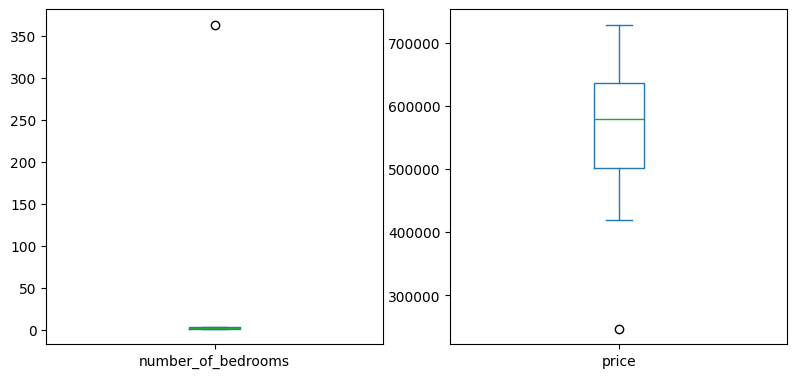

In [54]:
boxPlotAll(df[["number_of_bedrooms","price"]])

Using our domain knowledge, we recognise 363 bedrooms as an error, so we can replace the value with a null:

In [55]:
outliers_mask = find_outliers(df.number_of_bedrooms)
df.loc[outliers_mask,'number_of_bedrooms'] = np.nan

Or we could just remove the row:

## Duplicates
We can see if we have any duplicates:

In [56]:
# Find duplicates
df[df.duplicated()]

,location,date_of_sale,number_of_bedrooms,price,type
9,Camden,2001-12-16,1.0,616000.0,apartment


And remove them:

In [57]:
# Remove duplicates
df = df.drop_duplicates()

## Dealing with nulls

Now we need to turn our attention to the nulls in the data.  Let's find where there are nulls:

In [58]:
df.isnull().sum()

location              0
date_of_sale          0
number_of_bedrooms    3
price                 2
type                  0
dtype: int64

### Strategy 1: Remove all columns containing nulls

In [59]:
# Remove columns containing nulls
df_dropcols = df.dropna(axis=1)
df_dropcols

,location,date_of_sale,type
0,Clapham,1999-04-12,apartment
1,Ashford,2017-08-05,semi-detached
2,Stratford-on-Avon,2012-03-29,detached
3,Canterbury,2009-07-01,terraced
4,Camden,2001-12-16,apartment
5,Rugby,2003-03-01,detached
6,Hampstead,2016-03-05,terraced
7,Clapham,2001-07-05,apartment
8,Stratford-on-Avon,2010-05-10,detached


### Strategy 2: Remove all rows containing nulls

In [60]:
# Remove rows containing nulls
df_droprows = df.dropna()
df_droprows

,location,date_of_sale,number_of_bedrooms,price,type
0,Clapham,1999-04-12,1.0,729000.0,apartment
3,Canterbury,2009-07-01,2.0,529000.0,terraced
4,Camden,2001-12-16,1.0,616000.0,apartment
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached


### Strategy 3: Impute nulls with the mean for the column

Impute with mean

In [61]:
mean = df["price"].mean()       # calculate the mean for the column
df["price"].fillna(value=mean)  # replace nulls with the mean

0    729000.000000
1    699000.000000
2    540428.571429
3    529000.000000
4    616000.000000
5    247000.000000
6    540428.571429
7    543000.000000
8    420000.000000
Name: price, dtype: float64

### Strategy 4: Impute nulls with the median for the column

Impute with median

In [62]:
median = df["price"].median()   # calculate the median for the column
df["price"].fillna(value=median)  # replace nulls with the mean

0    729000.0
1    699000.0
2    543000.0
3    529000.0
4    616000.0
5    247000.0
6    543000.0
7    543000.0
8    420000.0
Name: price, dtype: float64

### Impute nulls in number_of_bedrooms

In [63]:
mean = round(df["number_of_bedrooms"].mean()) 

Let's decide to impute number of bedrooms with the mean

In [64]:
mean = round(df["number_of_bedrooms"].mean())     # calculate the mean for the column
df.loc[df["number_of_bedrooms"].isnull(), "number_of_bedrooms"] = mean

In [65]:
df

,location,date_of_sale,number_of_bedrooms,price,type
0,Clapham,1999-04-12,1.0,729000.0,apartment
1,Ashford,2017-08-05,2.0,699000.0,semi-detached
2,Stratford-on-Avon,2012-03-29,3.0,NaN,detached
3,Canterbury,2009-07-01,2.0,529000.0,terraced
4,Camden,2001-12-16,1.0,616000.0,apartment
5,Rugby,2003-03-01,2.0,247000.0,detached
6,Hampstead,2016-03-05,2.0,NaN,terraced
7,Clapham,2001-07-05,2.0,543000.0,apartment
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached


### Impute nulls in price

We may take a more sophisticated approach and look at the mean or median based on a subgroup, e.g. the mean price in each location for each year of sale.  For any property in Stratford-Upon_avon will a null price, we impute with the mean for Stratford for the year of sale.., etc.

We need to compute the year of sale:

In [66]:
mean = round(df["price"].median())     # calculate the mean for the column
df.loc[df["price"].isnull(), "price"] = mean

In [67]:
# Compute year
df = df.copy()
df.loc[:, 'year'] = df['date_of_sale'].dt.year
df

,location,date_of_sale,number_of_bedrooms,price,type,year
0,Clapham,1999-04-12,1.0,729000.0,apartment,1999
1,Ashford,2017-08-05,2.0,699000.0,semi-detached,2017
2,Stratford-on-Avon,2012-03-29,3.0,543000.0,detached,2012
3,Canterbury,2009-07-01,2.0,529000.0,terraced,2009
4,Camden,2001-12-16,1.0,616000.0,apartment,2001
5,Rugby,2003-03-01,2.0,247000.0,detached,2003
6,Hampstead,2016-03-05,2.0,543000.0,terraced,2016
7,Clapham,2001-07-05,2.0,543000.0,apartment,2001
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached,2010


We can compute the mean for each location, property size and year of sale using a groupby:

In [68]:
df.groupby(['location','number_of_bedrooms','year'])['price'].mean()

location           number_of_bedrooms  year
Ashford            2.0                 2017    699000.0
Camden             1.0                 2001    616000.0
Canterbury         2.0                 2009    529000.0
Clapham            1.0                 1999    729000.0
                   2.0                 2001    543000.0
Hampstead          2.0                 2016    543000.0
Rugby              2.0                 2003    247000.0
Stratford-on-Avon  3.0                 2010    420000.0
                                       2012    543000.0
Name: price, dtype: float64

And we can carry out the imputation using the above means like this:

In [32]:
df.loc[:, 'price'] = df.groupby(['location', 'number_of_bedrooms', 'year'])['price'].transform(lambda x: x.fillna(x.mean()))

Now, because we have such a small data set, we don't have enough data to calculate a mean for all our combinations of location, number_of_bedrooms and year.  So we have nulls in our groupings above and will have nulls in our imputed data:

In [33]:
df

,location,date_of_sale,number_of_bedrooms,price,type,year
0,Clapham,1999-04-12,1.0,729000.0,apartment,1999
1,Ashford,2017-08-05,2.0,699000.0,semi-detached,2017
2,Stratford-on-Avon,2012-03-29,3.0,543000.0,detached,2012
3,Canterbury,2009-07-01,2.0,529000.0,terraced,2009
4,Camden,2001-12-16,1.0,616000.0,apartment,2001
5,Rugby,2003-03-01,2.0,247000.0,detached,2003
6,Hampstead,2016-03-05,2.0,543000.0,terraced,2016
7,Clapham,2001-07-05,2.0,543000.0,apartment,2001
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached,2010


In this case we can simplify our grouping to find the mean price for any property, in any location and sold at any time:

In [34]:
df.groupby(['number_of_bedrooms'])['price'].mean()

number_of_bedrooms
1.0    672500.0
2.0    512200.0
3.0    481500.0
Name: price, dtype: float64

In [37]:
df.groupby(['number_of_bedrooms'])['price'].transform(lambda x: x.fillna(x.mean()))

0    729000.0
1    699000.0
2    543000.0
3    529000.0
4    616000.0
5    247000.0
6    543000.0
7    543000.0
8    420000.0
Name: price, dtype: float64

We can now see the nulls in price have been removed:

In [36]:
df

,location,date_of_sale,number_of_bedrooms,price,type,year
0,Clapham,1999-04-12,1.0,729000.0,apartment,1999
1,Ashford,2017-08-05,2.0,699000.0,semi-detached,2017
2,Stratford-on-Avon,2012-03-29,3.0,543000.0,detached,2012
3,Canterbury,2009-07-01,2.0,529000.0,terraced,2009
4,Camden,2001-12-16,1.0,616000.0,apartment,2001
5,Rugby,2003-03-01,2.0,247000.0,detached,2003
6,Hampstead,2016-03-05,2.0,543000.0,terraced,2016
7,Clapham,2001-07-05,2.0,543000.0,apartment,2001
8,Stratford-on-Avon,2010-05-10,3.0,420000.0,detached,2010


This illustrates how a multi-stage imputation can be carried out (in this case first impute with mean for location, number_of_bedrooms and year, then impute just for number_of_bedrooms).